# PROJET DATA MANAGEMENT & VISUALISATION - DU SDA- 2025/2026

## Analyse du dataset OWID COVID-19

**Thématique :** Santé publique & épidémiologie  
**Source des données :** Our World in Data (OWID)  
**Objectif :** Explorer, nettoyer, enrichir et visualiser un jeu de données
de grande dimension (>200 000 lignes), puis proposer une analyse textuelle
en lien avec le thème sanitaire dans une web application.

Ce notebook couvre l'étape de **Data Management** du projet plus complet qui a aboutit à une application sous streamlit:
1.  **Analyse exploratoire** (Structure, manquants, types).
2.  **Nettoyage des données** (Traitement des incohérences, doublons, NaNs).
3.  **Feature Engineering** (Création de deux nouvelles variables).



**Membres du groupe :** Ibrahima Bâ, Mahamat Sultan, Moustapha Mendy

In [1]:
# 1. IMPORTS ET CONFIGURATION
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration esthétique
sns.set_theme(style="whitegrid")
pd.set_option('display.max_columns', 50)

print("Librairies importées.")

Librairies importées.


## 2. CHARGEMENT ET ANALYSE EXPLORATOIRE (EDA)

In [2]:
# Chargement des données
DATA_PATH = "owid-covid-data.csv"

try:
    df = pd.read_csv(DATA_PATH, low_memory=False)
    print(f"✅ Dataset chargé : {df.shape[0]} lignes, {df.shape[1]} variables.")
except FileNotFoundError:
    print("❌ Erreur : Le fichier est introuvable. Vérifiez le chemin.")

# Aperçu des données
df.head()

✅ Dataset chargé : 429435 lignes, 67 variables.


iso_code continent     location        date  total_cases  new_cases  \
0      AFG      Asia  Afghanistan  2020-01-05          0.0        0.0   
1      AFG      Asia  Afghanistan  2020-01-06          0.0        0.0   
2      AFG      Asia  Afghanistan  2020-01-07          0.0        0.0   
3      AFG      Asia  Afghanistan  2020-01-08          0.0        0.0   
4      AFG      Asia  Afghanistan  2020-01-09          0.0        0.0   

   new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  \
0                 NaN           0.0         0.0                  NaN   
1                 NaN           0.0         0.0                  NaN   
2                 NaN           0.0         0.0                  NaN   
3                 NaN           0.0         0.0                  NaN   
4                 NaN           0.0         0.0                  NaN   

   total_cases_per_million  new_cases_per_million  \
0                      0.0                    0.0   
1                      0.0                    0.0   
2                      0.0                    0.0   
3                      0.0                    0.0   
4                      0.0                    0.0   

   new_cases_smoothed_per_million  total_deaths_per_million  \
0                             NaN                       0.0   
1                             NaN                       0.0   
2                             NaN                       0.0   
3                             NaN                       0.0   
4                             NaN                       0.0   

   new_deaths_per_million  new_deaths_smoothed_per_million  reproduction_rate  \
0                     0.0                              NaN                NaN   
1                     0.0                              NaN                NaN   
2                     0.0                              NaN                NaN   
3                     0.0                              NaN                NaN   
4                     0.0                              NaN                NaN   

   icu_patients  icu_patients_per_million  hosp_patients  \
0           NaN                       NaN            NaN   
1           NaN                       NaN            NaN   
2           NaN                       NaN            NaN   
3           NaN                       NaN            NaN   
4           NaN                       NaN            NaN   

   hosp_patients_per_million  weekly_icu_admissions  \
0                        NaN                    NaN   
1                        NaN                    NaN   
2                        NaN                    NaN   
3                        NaN                    NaN   
4                        NaN                    NaN   

   weekly_icu_admissions_per_million  weekly_hosp_admissions  \
0                                NaN                     NaN   
1                                NaN                     NaN   
2                                NaN                     NaN   
3                                NaN                     NaN   
4                                NaN                     NaN   

   weekly_hosp_admissions_per_million  ...  \
0                                 NaN  ...   
1                                 NaN  ...   
2                                 NaN  ...   
3                                 NaN  ...   
4                                 NaN  ...   

   people_fully_vaccinated_per_hundred  total_boosters_per_hundred  \
0                                  NaN                         NaN   
1                                  NaN                         NaN   
2                                  NaN                         NaN   
3                                  NaN                         NaN   
4                                  NaN                         NaN   

   new_vaccinations_smoothed_per_million  new_people_vaccinated_smoothed  \
0                                    NaN                             NaN   
1                 

### 2.1 Vérification de la structure
Nous vérifions ici les types de variables et la présence de valeurs manquantes.

In [3]:
# Types des colonnes principales
print(df[['iso_code', 'date', 'total_cases', 'population']].dtypes)

# Visualisation des valeurs manquantes (Heatmap)
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title("Carte des valeurs manquantes (Jaune = NaN)")
plt.show()

iso_code        object
date            object
total_cases    float64
population       int64
dtype: object


## 3. NETTOYAGE DES DONNÉES
Cette étape vise à traiter les incohérences et les valeurs manquantes pour préparer l'analyse.

### 3.1 Suppression des agrégats (OWID)
**Problème :** Le dataset contient des lignes régionales (Europe, Monde, Pays à haut revenu) qui faussent les calculs statistiques par pays.
**Décision :** Suppression de toutes les lignes dont l'`iso_code` commence par "OWID".

In [4]:
initial_rows = df.shape[0]

# Filtre des lignes OWID
df_clean = df[~df['iso_code'].str.startswith('OWID')].copy()
df_clean = df_clean.dropna(subset=['iso_code'])

deleted_rows = initial_rows - df_clean.shape[0]
print(f"Nettoyage effectué : {deleted_rows} lignes supprimées (Agrégats régionaux).")

Nettoyage effectué : 34124 lignes supprimées (Agrégats régionaux).


### 3.2 Imputation des valeurs manquantes
**Problème :** Les colonnes de flux quotidiens (`new_cases`, `new_deaths`) contiennent des NaN.
**Justification :** Dans le contexte épidémiologique, une absence de rapport journalier est traitée comme 0 cas/décès pour ce jour précis afin de maintenir la continuité des séries temporelles.

In [5]:
cols_to_impute = ['new_cases', 'new_deaths', 'total_vaccinations_per_hundred', 'stringency_index']

print("Manquants avant imputation :")
print(df_clean[cols_to_impute].isna().sum())

for col in cols_to_impute:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].fillna(0)

# Conversion de la date au format datetime
df_clean['date'] = pd.to_datetime(df_clean['date'])

Manquants avant imputation :
new_cases                           6914
new_deaths                          6465
total_vaccinations_per_hundred    328776
stringency_index                  200213
dtype: int64


## 4. CRÉATION DE VARIABLES (FEATURE ENGINEERING)
Conformément au cahier des charges, nous générons deux nouvelles variables pertinentes.

### Variable 1 : Cas par million d'habitants (`cases_per_million`)
**Objectif :** Normaliser les données pour comparer des pays de tailles différentes.

In [6]:
if 'population' in df_clean.columns:
    df_clean['cases_per_million'] = (df_clean['new_cases'] / df_clean['population']) * 1000000
    df_clean['cases_per_million'] = df_clean['cases_per_million'].fillna(0)
    
    print("Variable créée : 'cases_per_million'")
    display(df_clean[['location', 'date', 'new_cases', 'cases_per_million']].sample(5))

Variable créée : 'cases_per_million'


location       date  new_cases  cases_per_million
80065           Congo 2023-10-09        0.0           0.000000
99115        Dominica 2020-11-27        0.0           0.000000
133344  French Guiana 2023-07-31        0.0           0.000000
71190            Chad 2022-05-22        1.0           0.056423
426169         Zambia 2020-03-27        0.0           0.000000

### Variable 2 : Niveau de Rigueur (`policy_level`)
**Objectif :** Catégoriser l'indice numérique `stringency_index` en niveaux lisibles (Faible, Modéré, Élevé) pour l'analyse qualitative.

In [7]:
conditions = [
    (df_clean['stringency_index'] < 30),
    (df_clean['stringency_index'] >= 30) & (df_clean['stringency_index'] < 60),
    (df_clean['stringency_index'] >= 60)
]
choices = ['Basse rigueur', 'Rigueur modérée', 'Rigueur élevée']

df_clean['policy_level'] = np.select(conditions, choices, default='Inconnu')

print("Variable créée : 'policy_level'")
print(df_clean['policy_level'].value_counts())

Variable créée : 'policy_level'
Basse rigueur      265800
Rigueur modérée     75608
Rigueur élevée      53903
Name: policy_level, dtype: int64


## 5. VISUALISATION DES TENDANCES
Vérification visuelle de la cohérence des données traitées.

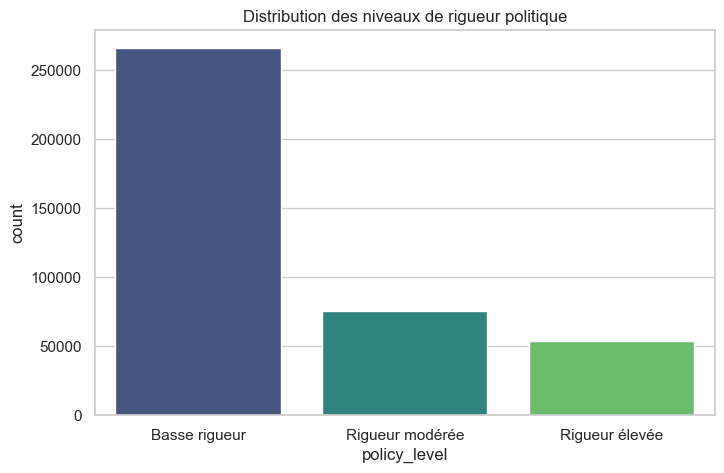

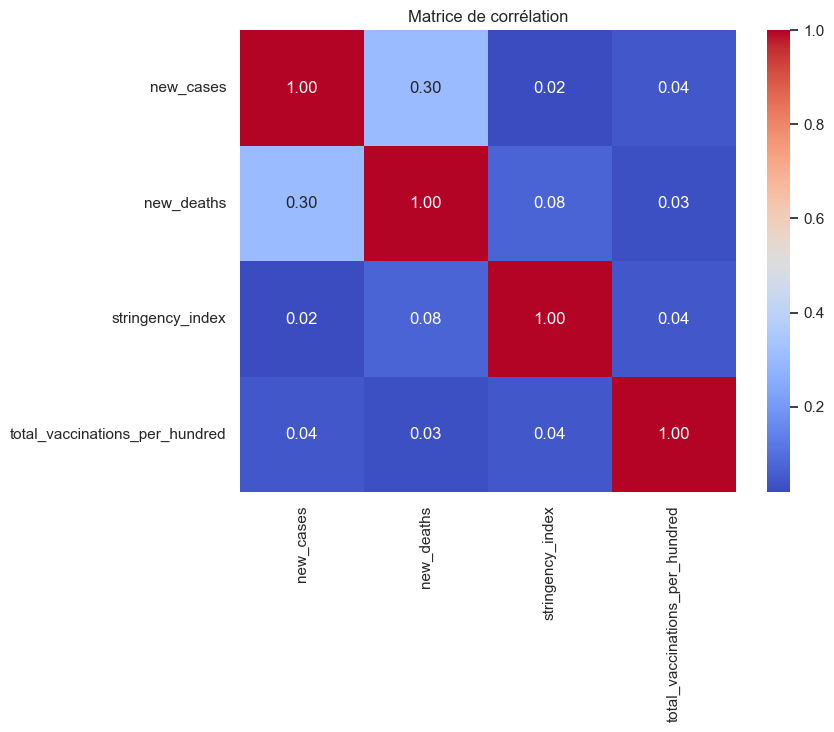

In [8]:
# Visualisation 1 : Distribution des politiques sanitaires
plt.figure(figsize=(8, 5))
sns.countplot(x='policy_level', data=df_clean, palette='viridis', order=['Basse rigueur', 'Rigueur modérée', 'Rigueur élevée'])
plt.title("Distribution des niveaux de rigueur politique")
plt.show()

# Visualisation 2 : Corrélation entre variables
plt.figure(figsize=(8, 6))
corr_cols = ['new_cases', 'new_deaths', 'stringency_index', 'total_vaccinations_per_hundred']
sns.heatmap(df_clean[corr_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice de corrélation")
plt.show()

## 6. CONCLUSION
Le jeu de données est nettoyé et enrichi. Ces traitements sont reproduits dans le script `covid.py` pour l'application Streamlit.